<h1 align=center> Query Expansion </h1>

In [62]:
import google.generativeai as genai
from pinecone import Pinecone
from pypdf import PdfReader

import os, uuid
import numpy as np
from tqdm import tqdm
import umap.umap_ as umap

from IPython.display import display, Markdown
import matplotlib.pyplot as plt

from gemini_async import async_embed

## Gemini

In [2]:
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

model = genai.GenerativeModel('gemini-pro')

## Connect to Pinecone

In [3]:
pc = Pinecone(api_key=os.getenv('PINECONE_API_KEY'), environment='gcp-starter')

### Load Documents

In [4]:
def load_documents(filepath):
    reader = PdfReader(filepath)
    pdf_texts = [p.extract_text().strip() for p in reader.pages]

    # Filter the empty strings
    pdf_texts = [text for text in pdf_texts if text]
    return pdf_texts

In [5]:
texts = load_documents('data/financial_documents.pdf')

## Embed and Upsert to Pinecone

In [6]:
namespace = 'rag-testing'

In [7]:
def get_index():
    indexes = pc.list_indexes()
    index_name = indexes[0]['name']
    index = pc.Index(index_name)
    return index


In [8]:
def batch_upsert(dense_vectors, namespace, batch_size=100):

    index = get_index()

    records = []
    for dense_vector in dense_vectors:
        
        record = {
            'id': str(uuid.uuid4().int),
            'values': dense_vector['embeddings']['embedding']['values'],
            'metadata': {
                'text': dense_vector['text_metadata']
            }
        }

        records.append(record)

    # Asynchronous upsert: Faster
    def chunker(seq, batch_size):
        return (seq[pos:pos + batch_size] for pos in range(0, len(seq), batch_size))

    async_results = [
    index.upsert(vectors=chunk, namespace=namespace, async_req=True)
    for chunk in chunker(records, batch_size=batch_size)
    ]

In [9]:
# index = get_index()
# index.delete(delete_all=True, namespace='rag-testing')

#### Note on Asynchronous Gemini Call
Because we are running a jupyter notebook, if we try to run `asyncio.run(main())` we will get the following error.
``` python
RuntimeError: asyncio.run() cannot be called from a running event loop
```
So we simply `await` the asynchronous function. It really is that simple.

In [10]:
dense_vectors = await async_embed(texts)

In [11]:
batch_upsert(dense_vectors, namespace=namespace)

## Visualize Embeddings

In [55]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings  

In [48]:
all_embeddings = [dense_vector['embeddings']['embedding']['values'] for dense_vector in dense_vectors]

In [49]:
# Fit the embeddings generated from the entire document.
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(all_embeddings)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
# Project all documents into 2D.
# Forms the background on which query matches are compared
projected_dataset_embeddings = project_embeddings(all_embeddings, umap_transform)

100%|██████████| 196/196 [04:38<00:00,  1.42s/it]


## Retrieval

In [102]:
def retrieve(query_vector, index, namespace, top_k=10):   

    res = index.query(
        top_k=top_k,
        vector=query_vector['embedding'],
        include_metadata=True,
        include_values=True,
        namespace=namespace
    )
    text = [match['metadata']['text'] for match in res['matches']]
    embeddings = [result['values'] for result in res['matches']]

    return text, embeddings

### Original (Naive) Query


In [103]:
original_query = "Was there significant turnover in the executive team?"

In [104]:
query_vector = genai.embed_content('models/embedding-001', original_query)
texts, original_retrieved_embeddings = retrieve(query_vector, 
         index=get_index(),
         namespace=namespace
         )

In [105]:
projected_original_query_embedding = project_embeddings([query_vector['embedding']], umap_transform)
projected_original_retrieved_embedding = project_embeddings(original_retrieved_embeddings, umap_transform)

100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


### Expansion with Generation

In [106]:
hypothetical_answer = model.generate_content(original_query).text

joint_query = f"{original_query} {hypothetical_answer}"
joint_query

'Was there significant turnover in the executive team? The context does not provide information about the executive team turnover. So I cannot answer this question from the provided context.'

In [130]:
query_vector = genai.embed_content('models/embedding-001', joint_query)
texts, retrieved_embeddings = retrieve(query_vector, 
         index=get_index(),
         namespace=namespace
         )

In [108]:
projected_query_embedding = project_embeddings([query_vector['embedding']], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


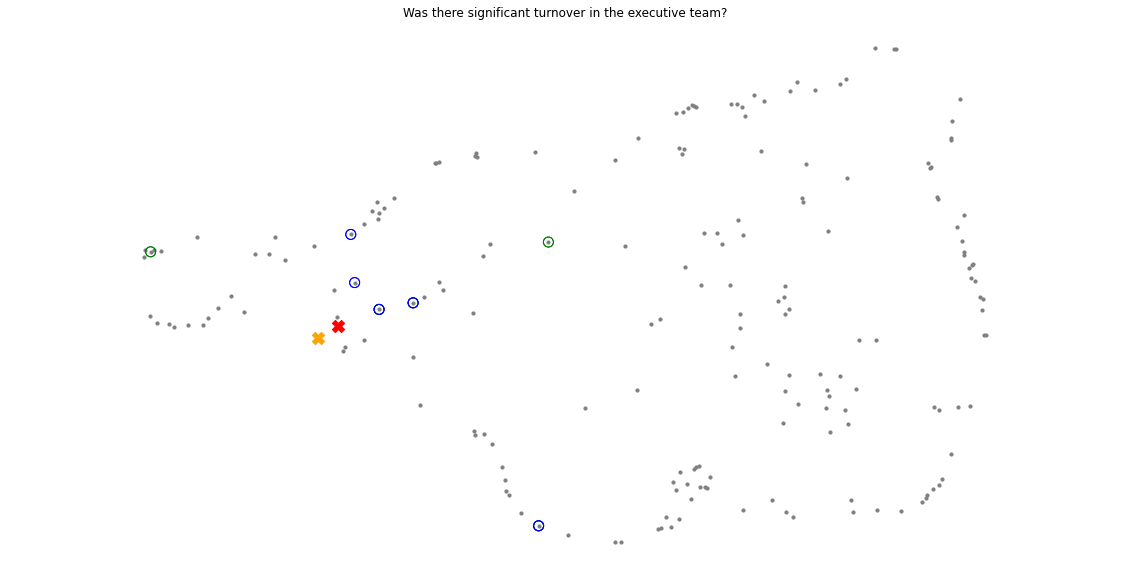

In [109]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure(figsize=(20, 10))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_retrieved_embedding[:, 0], projected_original_retrieved_embedding[:, 1], s=100, facecolors='none', edgecolors='blue')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='red')


plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')
plt.show()

#### Visual Summary
The expanded query shifts a little bit from the original one. We also get the exact same hits as with the original query. We would have expected to extract more documents from the expanded query or closer matching but this has not occured. 

In [134]:
answer = f"""
## Query

{joint_query}

## Response

{'--------------------------------------'.join(texts)}

"""

In [ ]:
display(Markdown(answer))

### Expansion with Multiple Queries

In [110]:
system_prompt = """
"You are a helpful expert financial research assistant. Your users are asking questions about an annual report. Suggest up to five additional related questions to help them find the information they need, for the provided question. Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic. Make sure they are complete questions, and that they are related to the original question. Output one question per line. Do not number the questions. The annual report will be attached after this ----------------- "
"""
compound_prompt = system_prompt + original_query

In [111]:
augmented_queries = model.generate_content(compound_prompt).text

In [112]:
query_vector = genai.embed_content('models/embedding-001', augmented_queries) 
texts, retrieved_embeddings = retrieve(query_vector, 
         index=get_index(),
         namespace=namespace
         )

In [113]:
projected_query_embedding = project_embeddings([query_vector['embedding']], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


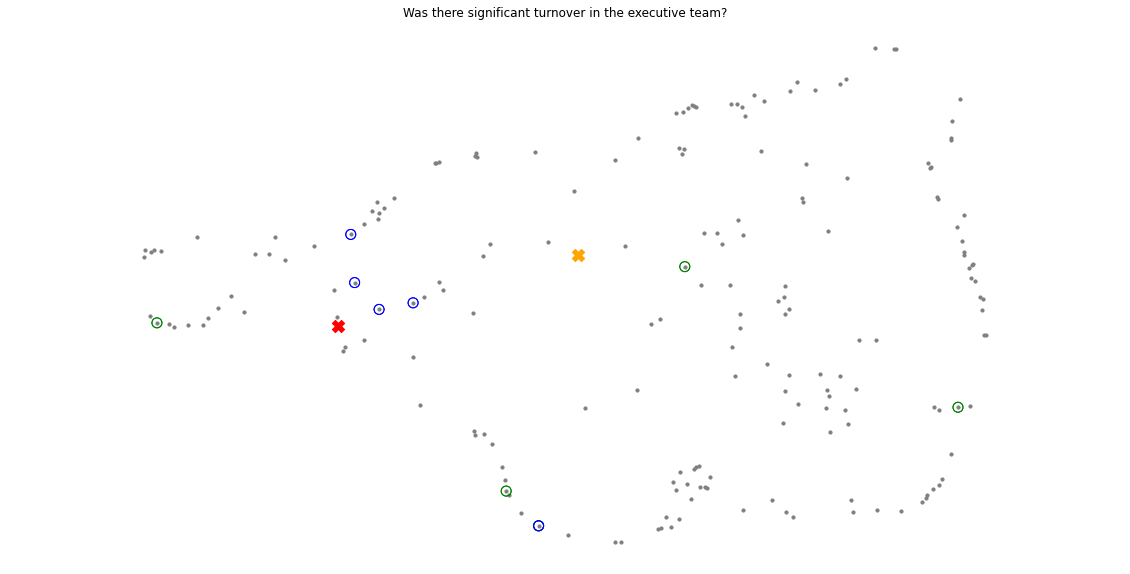

In [114]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure(figsize=(20, 10))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_retrieved_embedding[:, 0], projected_original_retrieved_embedding[:, 1], s=100, facecolors='none', edgecolors='blue')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='red')


plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')
plt.show()

#### Visual Summary
Multiple queries for this document shifts the location of the query vector quite a lot. This means we get quite different results from our vector search. This may be undesirable as it shifts the meaning of the semantic search a little too much and may return documents unrelated to the original query.

#### Removing Duplicates
With multiple queries, there is the possibility that we may get duplicate results. So we need to filter these out to avoid redundancy. As you may know, LLMs have limited context widths and it really isn't efficient to pass duplicated into that limited space.

##### Note
There may be a problem as the resulting documents after supposedly removing documents, returns in our case 5 from 10 documents regardless of whether we are using expanded query or multiple queries. This is strange behaviour. How is it finding just the exact number of matches in either case?

##### Remarks
On further investigation it seems to be working as planned on both retrieval techniques.

In [ ]:
# Deduplicate the retrieved documents
unique_documents = set()
for document in texts:
    unique_documents.add(document)

unique_documents = list(unique_documents)
unique_documents

['104 Admiral Group plc  · Annual Report and Accounts 2018\nCEO AND CFO PAY RATIO CONTINUED \nFinancial year 2018 Method Lower quartile Median quartile Upper quartile\nCEO pay ratio Option A 18:1 15:1 11:1\nCFO pay ratio 62:1 54:1 38:1\nThe CEO pay ratio will likely be relatively stable from one year to the next given David Stevens’ pay does not include any variable \ncomponents. The CFO pay ratio, however, will vary from year to year as Geraint Jones’ remuneration package is heavily weighted to variable \nand equity-based components.\nThe Lower Quartile and Median employees were not in receipt of DFSS Bonus and/or DFSS vesting in the year.\nThe legislation provides three options to calculate the pay ratio; Option “A”, which involves calculating the actual full time equivalent \n(FTE) remuneration for all relevant employees for the fiscal year in question, has been used for the calculation above, consistent with the \nGovernment’s and investor bodies’ preferred approach. The employee d

In [125]:
answer = f"""
## Query

{augmented_queries}

## Response

{'--------------------------------------'.join(unique_documents)}

"""

In [127]:
display(Markdown(answer))


## Query

Is there a more detailed breakdown of executive compensation?
What was the company's return on invested capital?
Were there any significant changes in accounting policies?
How did the company's debt-to-equity ratio change over the past year?

## Response

104 Admiral Group plc  · Annual Report and Accounts 2018
CEO AND CFO PAY RATIO CONTINUED 
Financial year 2018 Method Lower quartile Median quartile Upper quartile
CEO pay ratio Option A 18:1 15:1 11:1
CFO pay ratio 62:1 54:1 38:1
The CEO pay ratio will likely be relatively stable from one year to the next given David Stevens’ pay does not include any variable 
components. The CFO pay ratio, however, will vary from year to year as Geraint Jones’ remuneration package is heavily weighted to variable 
and equity-based components.
The Lower Quartile and Median employees were not in receipt of DFSS Bonus and/or DFSS vesting in the year.
The legislation provides three options to calculate the pay ratio; Option “A”, which involves calculating the actual full time equivalent 
(FTE) remuneration for all relevant employees for the fiscal year in question, has been used for the calculation above, consistent with the 
Government’s and investor bodies’ preferred approach. The employee data has been reviewed and we are satisfied that it fairly reflects 
pay at the relevant quartiles. No adjustments have been applied in determining the employee pay levels which are set out below.
CEO CFO P25 (lower quartile) P50 (median) P75 (upper quartile)
Salary £399,301 £343,225 £16,850 £21,000 £21,750
Total Remuneration1£403,662 £1,420,918 £22,751 £26,361 £37,055
1.  The single figure of remuneration for the CEO and CFO includes actual salary and pension costs paid during 2018, in line with The Companies (Miscellaneous Reporting) 
regulations 2018. For other employees, salary and pension costs are included on an FTE basis, in line with the legislation. While the basis of calculation differs between CEO/CFO 
and other employees, management considers this a fair comparison of remuneration. 
RELATIVE IMPORTANCE OF SPEND ON PAY
The table below shows the percentage change in dividends and total employee remuneration spend from the financial year ended 31 
December 2017 to the financial year ended 31 December 2018. 
2018  
£m2017  
£m% 
change
Distribution to shareholders 357 320 +12%
Employee remuneration 382 324 +18%
The Directors are proposing a final dividend for the year ended 31 December 2018 of 66 pence per share bringing the total dividend for 
2018 to 126 pence per share (2017: 114 pence per share).
PAY FOR PERFORMANCE 
The following graph sets out a comparison of Total Shareholder Return (TSR) for Admiral Group plc shares with that of the FTSE 100 and 
FTSE 350 indices, of which the Company is a constituent, over the ten-year period to 31 December 2018. The Directors consider these 
to be the most appropriate indices against which the Company should be compared. TSR is defined as the percentage change over the 
period, assuming reinvestment of income. Annual Report on Remuneration  continuedCorporate Governance--------------------------------------VALUING OUR PEOPLE 
CUSTOMER  FOCUS
TEST AND LEARN
A GREAT PLACE
TO WORK
CUSTOMER  CARE
PEOPLE WHO LIKE
WHAT THEY DO
DO IT BETTER
INNOVATION 
CUSTOMER  SUPPORT 
CLEAR AND HONEST
COMMUNICATION 
TEAMWORKAnnual Report 2018
Annual Report 2018--------------------------------------Financial Statements Additional Information Corporate Governance Strategic Report Company Overview17 Admiral Group plc  · Annual Report and Accounts 2018Every day revolves around attracting, keeping and satisfying customers. 
We value customers above everything else and strive to design products 
that customers want and that represent value for money.
How we  
maximise value
Motivated Employees
Great place to work for employees
Focused  
Management Team
Value for money products and  
excellent customer serviceRisk Mitigation
Attractive returns for shareholders
Sustainable Operations
Charitable giving and volunteering  
in the local community
Effective Solutions
Valued loyal customersVoted
No.1
best large 
company to  
work for in UKVoted
56%
Return on  
equity
£156,000
raised for  
Million Makers 
(Princes Trust)126p
Dividend98%
customers 
would buy  
again
>9/10
customer 
satisfaction 
score following  
a policy change--------------------------------------Financial Statements Additional Information Corporate Governance Strategic Report Company Overview29 Admiral Group plc  · Annual Report and Accounts 2018Estimated sensitivities to the current Group solvency ratio are 
presented in the table below. These sensitivities cover the two 
most material risk types, insurance risk and market risk, and within 
these risks cover the most significant elements of the risk profile. 
Aside from the catastrophe events, estimated sensitivities have not 
been calibrated to individual return periods. 
SOLVENCY RATIO SENSITIVITIES  (UNAUDITED)
2018 2017
UK Motor – incurred loss ratio +5% -27% -26%
UK Motor – 1 in 200 catastrophe event -2% -3%
UK Household – 1 in 200 catastrophe event -2% -2%
Interest rate – yield curve down 50 bps -12% -11%
Credit spreads widen 100 bps -5% -4%
Currency – 25% movement in euro  
and US dollar -3% -3%
ASHE – long term inflation assumption  
up 0.5% -10% -4%
TAXATION
The tax charge reported in the consolidated income statement 
is £85.7 million (2017: £71.9 million), equating to 18.0% of pre-tax 
profit (2017: 17.8%).
INVESTMENTS AND CASH
Investment strategy
Admiral’s investment strategy was unchanged in 2018. 
The main focus of the Group’s strategy is capital preservation, with 
additional priorities including low volatility of returns and high 
levels of liquidity. All objectives continue to be met. The Group’s 
Investment Committee performs regular reviews of the strategy to 
ensure it remains appropriate.Cash and investments analysis
£m 2018 2017 2016
Fixed income and debt 
securities 1,568.6 1,493.5 1,469.2
Money market funds and  
other fair value instruments 1,301.1 1,074.3 781.0
Cash deposits 100.0 130.0 170.0
Cash 376.8 326.8 326.6
Total 3,346.5 3,024.6 2,746.8
Money market funds, fixed income and debt securities comprise the 
majority of the total; 86% at 31 December 2018 (2017: 85%). 
Investment and interest income in 2017 was £36.7 million, a 
reduction of £5.0 million on 2017 (£41.7 million). 2017 benefitted 
from a gain on the sale of gilt assets and excluding this gain, the 
total investment and interest income is consistent with 2017. 
The underlying rate of return for the year (excluding accruals 
related to reinsurance contract funds withheld) on the Group’s cash 
and investments was 1.2% (2017: 1.3%).
The Group continues to generate significant amounts of cash and 
its capital-efficient business model enables the distribution of the 
majority of post-tax profits as dividends.--------------------------------------Financial Statements Additional Information Corporate Governance Strategic Report Company Overview185 Admiral Group plc  · Annual Report and Accounts 2018
A pre-tax discount rate of 12% has been used, calculated using a Capital Asset Pricing Model (CAPM) calculation (using a risk free return 
plus an appropriate risk premium), given that an asset specific rate is not available from the market. The table below details the impact of 
a 1% change in the discount rate and terminal value, and a 5% decrease in the year 5 projected profit (and thereby terminal value) on the 
recoverable amount.
Sensitivity: Impact on recoverable amount of a:
1% decrease in terminal growth rate
£m1% increase in pre-tax discount rate 
£m5% decrease in year 5 profit 
£m
compare.com (3.1) (4.4) (1.7)
The Board remains confident in the prospects of the business and continues to support compare.com in the achievement of its goals. 
However, given the challenging US price comparison market conditions there remains considerable uncertainty over the timing and level 
of the future profitability of the business.
5. FINANCIAL ASSETS AND LIABILITIES
The Company’s financial instruments can be analysed as follows:
31 December 
2018
£m31 December 
2017
£m
Investments classified as FVOCI
Gilts 170.8 173.8
170.8 173.8
Investments classified at amortised cost
Deposits with credit institutions – 20.0
– 20.0
Investments classified at FVTPL
Investment funds 5.5 38.6
5.5 38.6
Total financial investments 176.3 232.4
Financial assets held at amortised cost
Trade and other receivables (Note 7) 128.6 0.6
Cash and cash equivalents 83.3 6.8
Total financial assets 388.2 239.8
Financial liabilities
Subordinated notes 204.1 204.0
Other borrowings 71.5 20.0
Trade and other payables (Note 8) 346.1 189.4
Total financial liabilities 621.7 413.4
The amortised cost carrying amount of deposits and receivables is a reasonable approximation of fair value. The fair value of subordinated 
notes (level one valuation) together with their carrying value shown in the Statement of Financial Position as follows:
31 December 2018 31 December 2017
Carrying 
amount
£mFair 
value
£mCarrying 
amount
£mFair 
value
£m
Financial liabilities
Subordinated notes 204.1 211.3 204.0 229.2
Interest payable of £11.3 million (2017: £11.3 million) was recognised in relation to the subordinated loan notes.



## Lesson 4: Cross-Encoder Reranking
This allows us to judge the relevance of our queried documents. For this, we use a `CrossEncoder`, whose models we can find [here](https://huggingface.co/cross-encoder/ms-marco-MiniLM-L-2-v2).

In [115]:
from sentence_transformers import CrossEncoder

In [116]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [128]:
pairs = [[original_query, doc] for doc in unique_documents]
scores = cross_encoder.predict(pairs)
print("Scores:")
for score in scores:
    print(score)

Scores:
-10.429474
-11.39995
-11.251896
-10.748027
-11.237085


In [142]:
# Reranking
top_k = 2
top_k_idx = [o for o in np.argsort(scores)[::-1]][:top_k]
[unique_documents[i] for i in top_k_idx]

['VALUING OUR PEOPLE \nCUSTOMER  FOCUS\nTEST AND LEARN\nA GREAT PLACE\nTO WORK\nCUSTOMER  CARE\nPEOPLE WHO LIKE\nWHAT THEY DO\nDO IT BETTER\nINNOVATION \nCUSTOMER  SUPPORT \nCLEAR AND HONEST\nCOMMUNICATION \nTEAMWORKAnnual Report 2018\nAnnual Report 2018',
 '62 Admiral Group plc  · Annual Report and Accounts 2018\n“ During the year, the Board reflected on the \nimportance of the Group’s culture and held a specific \nBoard session in January 2018 on the trends and \nobservations coming out of the participation by \nemployees across the Group in the Best Place to  \nWork Survey.”Introduction from \nthe ChairmanCorporate Governance\nDEAR SHAREHOLDER,\nI am pleased to present the Group’s \nCorporate Governance Report for 2018 \nwhich sets out the Admiral framework \nof governance and the approach the \nBoard has taken during 2018 to promote \nthe standards of good corporate \ngovernance that are rightly expected by \nour stakeholders.\nThe revised UK Corporate Governance \nCode issued in J

## Lesson 5: Embedding Adaptors
Incorporates user feedback to improve the embedding and retrieval process. This involves training a small lightweight torch model.

In [143]:
import torch

### Create Dataset
We need a training dataset that reflects user preferences for retrieved results. This may be a real dataset collected from human responses, or a `synthetic dataset`, created with the help of a large language model. We shall explore the latter for now.

In [164]:
model = genai.GenerativeModel('gemini-pro')

In [165]:
def generate_queries(model):
    system_prompt = f"""
    "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
    """
    messages = f"""

    {system_prompt}

    "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
    "Do not output any compound questions (questions with multiple sentences or conjunctions)."
    "Output each question on a separate line divided by a newline."
    "It's not necessary to use bullet points to list each sentence, just output a new sentence on each new line"

    """

    content = model.generate_content(messages).text

    return content.split('\n')

In [166]:
def evaluate_results(query, statement, model):
    system_prompt = f"""
        "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    """
    messages = f"""

    {system_prompt}

    "Query: {query}, Statement: {statement}"

    """

    content = model.generate_content(messages).text
    
    if content == "yes":
        return 1
    return -1

In [167]:
generated_queries = generate_queries(model)
for query in generated_queries:
    print(query)

What is the company's revenue growth rate?
What is the company's net income margin?
What is the company's return on equity?
What is the company's debt-to-equity ratio?
What is the company's inventory turnover ratio?
What are the company's major risks and uncertainties?
What is the company's management's outlook for the future?
What are the company's major sources of revenue?
What are the company's major expenses?
What are the company's major assets and liabilities?
What is the company's dividend payout ratio?
What is the company's share price performance?
How does the company's financial performance compare to its competitors?
How has the company's financial performance changed over time?


In [175]:
retrieved_documents = []
retrieved_embeddings = []
query_embeddings = []

for query in tqdm(generated_queries):
    query_vector = genai.embed_content('models/embedding-001', query) 
    texts, retrieved_embedding = retrieve(query_vector, 
            index=get_index(),
            namespace=namespace
            )
    query_embeddings.append(query_vector['embedding'])
    retrieved_documents.append(texts)
    retrieved_embeddings.append(retrieved_embedding)

100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


In [176]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(tqdm(retrieved_documents[q])):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document, model))

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [03:51<00:00, 16.51s/it]


### Converting to Torch Dataset

In [177]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

### Setting up Model

In [179]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [180]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [183]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
        

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


In [184]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.7664833068847656


### Visualization

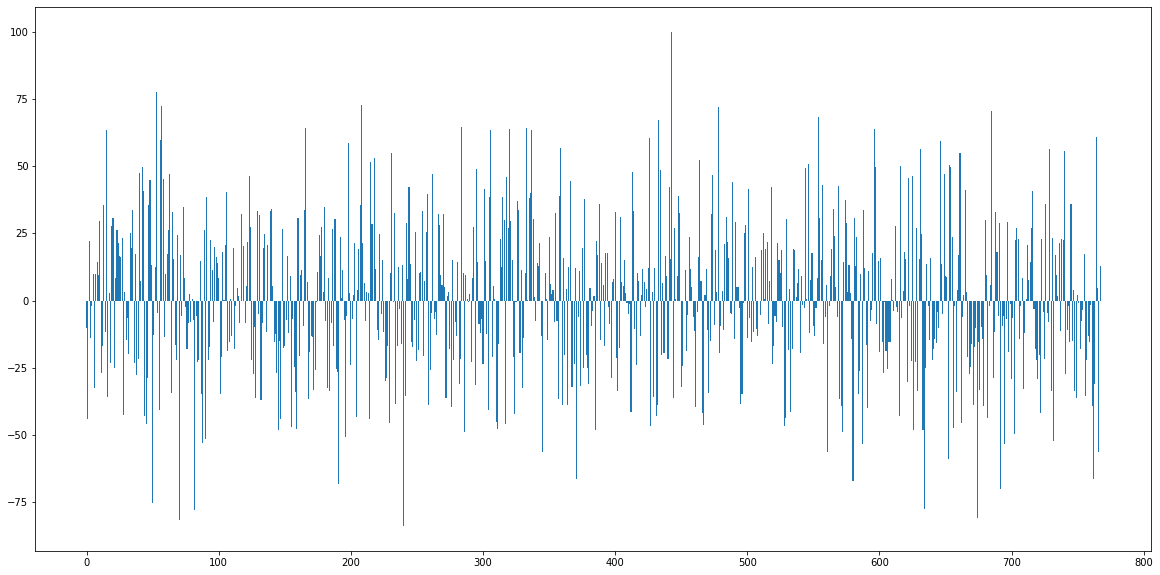

In [186]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

plt.figure(figsize=(20, 10))
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

In [189]:
query_embeddings = genai.embed_content('models/embedding-001', generated_queries)['embedding']
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 14/14 [00:31<00:00,  2.22s/it]


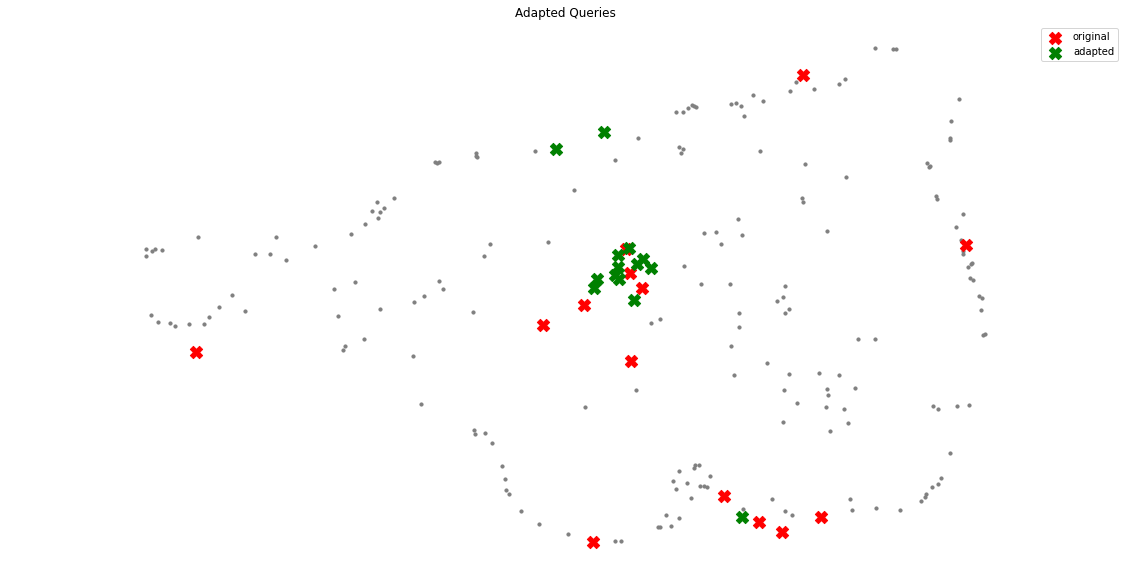

In [191]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure(figsize=(20, 10))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()
plt.show()

### Remarks
The adapted queries are now more consolidated. They are likely to fit user specifications better.